# Flocking behavior

This notebook presents an agent-based model that simulates the flocking behavior of animals. It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package for models with a continuous space with two or three dimensions.

In [68]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import matplotlib.pyplot as plt 
import IPython

## About the model

The boids model was invented by [Craig Reynolds](http://www.red3d.com/cwr/boids/), who describes it as follows:

> In 1986 I made a computer model of coordinated animal motion such as bird flocks and fish schools. It was based on three dimensional computational geometry of the sort normally used in computer animation or computer aided design. I called the generic simulated flocking creatures boids. The basic flocking model consists of three simple steering behaviors which describe how an individual boid maneuvers based on the positions and velocities its nearby flockmates:
> - Separation: steer to avoid crowding local flockmates
> - Alignment: steer towards the average heading of local flockmates
> - Cohesion: steer to move toward the average position of local flockmates 

The model presented here is a simplified implementation of this algorithm, following the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html) written by Conrad Parker.

If you want to see a real-world example of flocking behavior, check out this fascinating video of Starling murmurations from National Geographic:

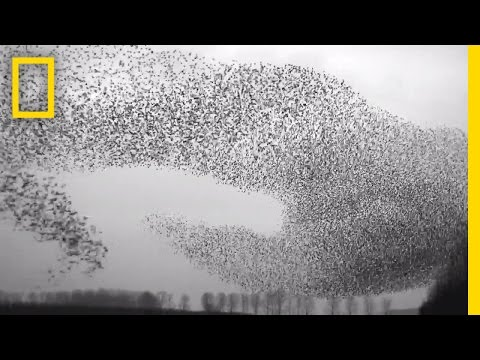

In [69]:
IPython.display.YouTubeVideo('V4f_1_r80RY', width=600, height=350)

## Model definition

The Boids model is based on two classes, one for the agents, and one for the overall model.
For more information about this structure, take a look at the [creating models](https://agentpy.readthedocs.io/en/latest/overview.html#creating-models).

Each agent starts with a random position and velocity, which are implemented as numpy [arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html).
The position is defined through the space environment,
which the agent can access via `Agent.position()` and `Agent.neighbors()`.

The methods `update_velocity()` and `update_position()` are separated so that all agents can
update their velocity before the actual movement takes place.
For more information about the algorithm in `update_velocity()`, 
check out the [Boids Pseudocode](http://www.vergenet.net/~conrad/boids/pseudocode.html).

In [70]:
def normalize(v):
    """ Normalize a vector to length 1. """
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

PAYOFFS = {
    # Classic Prisoner's Dilemma: T(4) > R(2) > P(3?) actually standard is T>R>P>S with typical numbers (4,3,1,0)
    # We'll use symmetrical: (D,D)=(1,1), (D,C)=(4,0), (C,D)=(0,4), (C,C)=(3,3)
    "pd": {
        ("D","D"): (1,1),
        ("D","C"): (4,0),
        ("C","D"): (0,4),
        ("C","C"): (3,3),
    },
    # Asymmetric variant (your Matrix A idea, slightly cleaned to be consistent as a game example)
    # Row: self, Col: nb. Keep asymmetry (leader/follower feel).
    "asym": {
        ("D","D"): (3,3),
        ("D","C"): (2,4),
        ("C","D"): (1,1),
        ("C","C"): (4,2),
    },
    # Anti-coordination variant (your Matrix B)
    "anti": {
        ("D","D"): (-1,-1),
        ("D","C"): (1,2),
        ("C","D"): (2,1),
        ("C","C"): (-1,-1),
    }
}

In [71]:
class Boid(ap.Agent):
    """Boid with game-theoretic strategy and payoff."""

    def setup(self): 
        self.velocity = normalize(self.model.nprandom.random(self.p.ndim) - 0.5)
        self.strategy = "C"  # will be overridden for leader and possibly randomized
        self.payoff = 0.0

    def setup_pos(self, space):
        self.space = space
        self.neighbors = space.neighbors
        self.pos = space.positions[self]

    # ----- Game logic -----

    def compute_pairwise_payoff(self):
        """Sum payoffs from pairwise interactions within outer_radius."""
        pm = self.model.payoff_matrix
        r = self.p.outer_radius
        total = 0.0
        # We compute self's payoff as first element of pair outcome
        for nb in self.neighbors(self, distance=r):
            a = self.strategy
            b = getattr(nb, "strategy", "C")
            total += pm[(a, b)][0]
        self.payoff = total

    def maybe_update_strategy(self):
        """Fermi imitation: pick a random neighbor; adopt their strategy with prob sigmoid(beta*(π_nb - π_self))."""
        if self.leader:
                self.strategy = "D"
                return
        nbs = [nb for nb in self.neighbors(self, distance=self.p.outer_radius) if not getattr(nb, "leader", False)]
        if not nbs:
            return
        nb = self.model.nprandom.choice(nbs)
        nb_payoff = getattr(nb, "payoff", 0.0)
        delta = nb_payoff - self.payoff
        beta = self.p.beta
        p_adopt = 1.0 / (1.0 + np.exp(-beta * delta))
        if self.model.nprandom.random() < p_adopt:
            self.strategy = nb.strategy

    # ----- Movement rules -----

    def update_velocity(self):
        pos = self.pos
        ndim = self.p.ndim

        # Strategy-based multipliers
        if self.strategy == "C":
            coh_mul = self.p.c_cohesion_mult
            ali_mul = self.p.c_alignment_mult
            lead_mul = self.p.c_leader_mult
            tgt_mul  = self.p.c_target_mult
        else:  # "D"
            coh_mul = self.p.d_cohesion_mult
            ali_mul = self.p.d_alignment_mult
            lead_mul = self.p.d_leader_mult
            tgt_mul  = self.p.d_target_mult

        # Rule 1 - Cohesion (not for leader)
        if not self.leader:
            nbs = list(self.neighbors(self, distance=self.p.outer_radius))
            nbs_len = len(nbs)
            if nbs_len > 0:
                nbs_pos_array = np.array([nb.pos for nb in nbs])
                center = np.sum(nbs_pos_array, axis=0) / nbs_len
                v1 = (center - pos) * self.p.cohesion_strength * coh_mul
            else:
                v1 = np.zeros(ndim)
        else:
            v1 = np.zeros(ndim)

        # Rule 2 - Separation (all boids)
        v2 = np.zeros(ndim)
        for nb in self.neighbors(self, distance=self.p.inner_radius):
            v2 -= nb.pos - pos
        v2 *= self.p.seperation_strength

        # Rule 3 - Alignment (not for leader)
        if not self.leader:
            if 'nbs_len' not in locals():
                nbs = list(self.neighbors(self, distance=self.p.outer_radius))
                nbs_len = len(nbs)
            if nbs_len > 0:
                nbs_vec_array = np.array([nb.velocity for nb in nbs])
                average_v = np.sum(nbs_vec_array, axis=0) / nbs_len
                v3 = (average_v - self.velocity) * self.p.alignment_strength * ali_mul
            else:
                v3 = np.zeros(ndim)
        else:
            v3 = np.zeros(ndim)

        # Rule 4 - Borders
        v4 = np.zeros(ndim)
        d = self.p.border_distance
        s = self.p.border_strength
        for i in range(ndim):
            if pos[i] < d:
                v4[i] += s
            elif pos[i] > self.space.shape[i] - d:
                v4[i] -= s

        # Rule 5 - Follow the leader (followers only)
        if not self.leader:
            leader = self.model.agents[0]
            v5 = (leader.pos - pos) * self.p.leader_strength * lead_mul
        else:
            v5 = np.zeros(ndim)

        # Rule 6 - Leader's movement (leader only)
        if self.leader:
            v6 = (self.model.current_target - pos) * self.p.target_strength * tgt_mul
        else:
            v6 = np.zeros(ndim)

        # Optional: a small exploration noise for defectors
        if self.strategy == "D" and self.p.d_noise > 0:
            v_noise = (self.model.nprandom.random(ndim) - 0.5) * self.p.d_noise
        else:
            v_noise = np.zeros(ndim)

        # Update velocity
        self.velocity += v1 + v2 + v3 + v4 + v5 + v6 + v_noise
        self.velocity = normalize(self.velocity)

    def update_position(self):
        self.space.move_by(self, self.velocity)   

In [72]:
class BoidsModel(ap.Model):
    """Boids with embedded game-theoretic strategy dynamics."""

    def setup(self):
        self.space = ap.Space(self, shape=[self.p.size]*self.p.ndim)
        self.agents = ap.AgentList(self, self.p.population, Boid)
        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)

        # Leader assignment
        for i, agent in enumerate(self.agents):
            agent.leader = (i == 0)

        # Targets
        self.stars = [self.space.shape * self.nprandom.random(self.p.ndim)
                      for _ in range(self.p.number_targets)]
        self.current_target = self.stars[0]

        # Choose payoff matrix
        self.payoff_matrix = PAYOFFS[self.p.game_type]

        # Initialize strategies
        # Leader defects; others random or specified initial cooperation rate
        init_p_coop = self.p.init_p_coop
        for i, a in enumerate(self.agents):
            if a.leader:
                a.strategy = "D"
            else:
                a.strategy = "C" if self.nprandom.random() < init_p_coop else "D"

        # For convenience
        self._update_every = self.p.strategy_update_interval

    def update_target(self):
        leader = self.agents[0]
        distance_to_target = np.linalg.norm(leader.pos - self.current_target)
        if distance_to_target < 2:
            self.current_target = self.stars[self.nprandom.choice(len(self.stars))]

    def strategy_update_phase(self):
        # 1) compute payoffs for all
        for a in self.agents:
            a.compute_pairwise_payoff()
        # 2) maybe update strategies
        for a in self.agents:
            a.maybe_update_strategy()

    def step(self):
        # Update strategies at chosen interval
        if self.t % self._update_every == 0:
            self.strategy_update_phase()

        self.update_target()
        self.agents.update_velocity()
        self.agents.update_position()

## Visualization functions

Next, we define a plot function that can take our model and parameters as an input and creates an animated plot with `animate()`:

In [73]:
def animation_plot_single(m, ax):
    ndim = m.p.ndim
    ax.set_title(f"Boids Game-Flocked {ndim}D t={m.t}")

    # Plot leader (red)
    if ndim == 2:
        ax.scatter(m.agents[0].pos[0], m.agents[0].pos[1], s=100, c='red', label='Leader (D)')
    else:
        ax.scatter(m.agents[0].pos[0], m.agents[0].pos[1], m.agents[0].pos[2], s=100, c='red', label='Leader (D)')
    ax.legend(loc='upper right')

    # Plot the targets (stars)
    for star in m.stars:
        if ndim == 2:
            ax.scatter(star[0], star[1], s=100, c='green', marker='*')
        else:
            ax.scatter(star[0], star[1], star[2], s=100, c='green', marker='*')

    # Followers colored by strategy: C=blue, D=orange
    pos = np.array([a.pos for a in m.agents[1:]])
    if len(pos) > 0:
        colors = ['tab:blue' if a.strategy == 'C' else 'tab:orange' for a in m.agents[1:]]
        if ndim == 2:
            ax.scatter(pos[:,0], pos[:,1], s=8, c=colors)
        else:
            ax.scatter(pos[:,0], pos[:,1], pos[:,2], s=8, c=colors)

    ax.set_xlim(0, m.p.size)
    ax.set_ylim(0, m.p.size)
    if ndim == 3:
        ax.set_zlim(0, m.p.size)
    ax.set_axis_off()
        
def animation_plot(m, p):
    projection = '3d' if p['ndim'] == 3 else None
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection=projection)
    animation = ap.animate(m(p), fig, ax, animation_plot_single)
    return IPython.display.HTML(animation.to_jshtml(fps=20))

## Simulation (2D)

To run a simulation, we define a dictionary with our parameters:

In [74]:
parameters2D = {  
    'size': 50,
    'seed': 123,
    'steps': 200,
    'ndim': 2,
    'population': 20,
    'inner_radius': 3,
    'outer_radius': 10,
    'border_distance': 10,
    'cohesion_strength': 0.005,
    'seperation_strength': 0.1,
    'alignment_strength': 0.3,
    'border_strength': 0.5,
    'leader_strength': 0.1,
    'number_targets': 4,
    'target_strength': 0.15,

    # ---- Game params ----
    'game_type': 'asym',                 # 'pd' | 'asym' | 'anti'
    'beta': 0.8,                       # Fermi selection intensity (0 ~ random, higher ~ greedier imitation)
    'strategy_update_interval': 3,     # how often to update strategies (in steps)
    'init_p_coop': 0.7,                # initial share of cooperators (followers)

    # Motion multipliers by strategy
    # Cooperators: stickier to flock, normal leader/target pull
    'c_cohesion_mult': 1.0,
    'c_alignment_mult': 1.0,
    'c_leader_mult': 1.0,
    'c_target_mult': 1.0,

    # Defectors: less cohesion/alignment, a bit more leader/target pull, plus little noise
    'd_cohesion_mult': 0,
    'd_alignment_mult': 0,
    'd_leader_mult': 0,
    'd_target_mult': 0,
    'd_noise': 0.15
}

We can now display our first animation with two dimensions:

In [75]:
animation_plot(BoidsModel, parameters2D)

## Simulation (3D)

Finally, we can do the same with three dimensions, a larger number of agents, and a bit more space:

In [76]:
new_parameters = {  
    'ndim': 3,
    'population': 20,
} 

parameters3D = dict(parameters2D)
parameters3D.update(new_parameters)

animation_plot(BoidsModel, parameters3D)